## Procesamiento Digital de Imagenes - TP5


### Functions and libraries

In [80]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import scipy.signal

### FFT amplitude and phase

In [81]:
def fft2_ap(im):
    im_f = np.fft.fftshift(np.fft.fft2(im))
    amp = np.abs(im_f)
    phase = np.angle(im_f)
    # normalize amplitude:
    s = np.array(im.shape).prod()
    amp /= s
    return amp, phase

### Compute IFFT

In [82]:
def ifft2_ap(amp, phase):
    s = np.array(amp.shape).prod()
    im_f = s * amp * (np.cos(phase)+1j *np.sin(phase))
    im = np.fft.ifft2(np.fft.ifftshift(im_f))
    return im.real

### Resample

In [83]:
def fft_resample(im, new_shape):
    fac = np.array(new_shape).prod() / np.array(im.shape).prod()
    im_f = np.fft.fftshift(np.fft.fft2(im * fac))
    # crop or pad:
    diff = (np.array(new_shape)-np.array(im.shape))//2
    crop = np.maximum(0, -diff)
    im_f = im_f[crop[0] : im.shape[0] - crop[0], crop[1] : im.shape[1] - crop[1]]
    pad = np.maximum(0, diff)
    im_f = np.pad(im_f,([pad[0], pad[0]], [pad[1], pad[1]]), 'empty')
    rec = np.clip(np.fft.ifft2(np.fft.ifftshift(im_f)).real, 0, 1)
    return rec

### Convolve

In [84]:
def convolve(image, kernel, mode):
    # stride to move the kernel over the image
    strides = 1
  
    # image and kernel shape
    x_kernel = kernel.shape[0]
    y_kernel = kernel.shape[1]
    x_image = image.shape[0]
    y_image = image.shape[1]

    # output shape
    x_output = int(((x_image - x_kernel) / strides) + 1)
    y_output = int(((y_image - y_kernel) / strides) + 1)
    output = np.zeros((x_output, y_output), dtype = 'float64')

    for y in range(image.shape[1]):
        if y > image.shape[1] - y_kernel:
            break
        # convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # go to next row once kernel is out of bounds
                if x > image.shape[0] - x_kernel:
                    break
                try:
                    # convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * image[x: x + x_kernel, y: y + y_kernel]).sum()
                except:
                    break

    return coerce(output)

In [85]:
def coerce(matrix):
  matrix[matrix > 1] = 1
  matrix[matrix < 0] = 0
  return matrix

### Gaussian kernel

In [86]:
def gauss(size, sigma = 1):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

### Box kernel

In [87]:
def box(n):
  box_kernel = np.ones((n, n))
  return box_kernel/np.sum(box_kernel)

### Circle kernel

In [88]:
def circle(h, w):
  center = (int(w/2), int(h/2))
  radius = min(center[0], center[1], w-center[0], h-center[1])

  Y, X = np.ogrid[:h, :w]
  dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

  mask = dist_from_center <= radius
  mask = np.where(mask == True, 1, 0)
  return mask/np.sum(mask)

### Laplace kernels

In [89]:
def laplace_4_neighbours():
  return np.array(
      [[0, -1, 0],
       [-1, 4, -1],
       [0, -1, 0]]
  )

In [90]:
def laplace_8_neighbours():
  return np.array(
      [[-1, -1, -1],
       [-1, 8, -1],
       [-1, -1, -1]]
  )

### High pass from low pass kernel

In [91]:
def identity_kernel(n): # It returns a matrix with all zeros, and a one in the middle (for odd sizes)
  identity_kernel = np.zeros((n, n))
  position = int(np.floor(n/2))
  identity_kernel[position, position] = 1
  return identity_kernel

In [92]:
def high_pass(low_pass):
  id = identity_kernel(low_pass.shape[0])
  return id - low_pass

### Band pass DoG

In [93]:
def dog(size, fine, coarse):
  fine_gaussian = gauss(size, fine)
  coarse_gaussian = gauss(size, coarse)
  return fine_gaussian - coarse_gaussian

### Contrast enhancement filter

In [94]:
def enhance(size):
  high_pass_filter = high_pass(gauss(size))
  identity = identity_kernel(size)
  return identity + 0.2*high_pass_filter

### Sobel

In [95]:
def sobel(size):
    radius = size//2
    G_x = np.zeros((size, size))
    G_y = np.zeros((size, size))
    for r in range(size):
        for c in range(size):
            if r == radius and c == radius:
                G_x[r,c] = 0
                G_y[r,c] = 0
            else:
                G_x[r,c] = (c-radius)/((r-radius)**2 + (c-radius)**2) 
                G_y[r,c] = (r-radius)/((r-radius)**2 + (c-radius)**2)
    return G_x, G_y

### Edge detection

In [96]:
def edge_detection(image, size=3):
    G_x, G_y = sobel(size)
    x_gradient = scipy.signal.convolve(image, G_x)
    y_gradient = scipy.signal.convolve(image, G_y)
    amplitude = np.sqrt(x_gradient**2 + y_gradient**2)
    phase = np.arctan2(y_gradient, x_gradient)
    return (amplitude, phase)

In [97]:
def edge_detection_from_gradientes(x_gradient, y_gradient):
    amplitude = np.sqrt(x_gradient**2 + y_gradient**2)
    phase = np.arctan2(y_gradient, x_gradient)
    return (amplitude, phase)

### Sobel–Feldman Scharr optimized

In [98]:
def sobel_optimized():
  gx = np.array(
      [[3, 0, -3],
       [10, 0, -10],
       [3, 0, -3]]
  )

  gy = np.array(
      [[3, 10, 3],
       [0, 0, 0],
       [-3, -10, -3]]
  )
  return [gx, gy]

### Scharr operator

In [99]:
def scharr():
  gx = np.array(
      [[47, 0, -47],
       [162, 0, -162],
       [47, 0, -47]]
  )

  gy = np.array(
      [[47, 162, 47],
       [0, 0, 0],
       [-47, -162, -47]]
  )
  return [gx, gy]

### Starting snippet

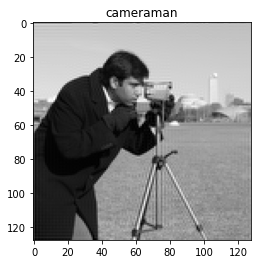

In [100]:
camera = imageio.imread('imageio:camera.png')/255.
im = fft_resample(camera, (128,128))
plt.imshow(im,'gray')
plt.title('cameraman')
plt.show()

# some more useful plots for kernels
def _surf(data):
    s = data.shape
    y, x = np.meshgrid(np.arange(s[0]),np.arange(s[1]),indexing='ij')
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    _min = np.min(data)
    _max = np.max(data)
    ax.plot_surface(x,y,data.T,cmap=cm.jet,vmin=_min,vmax=_max)

### Implement convolution as in scipy (only mode 'valid')

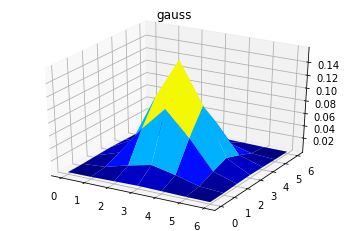

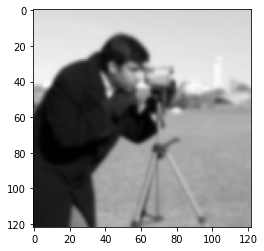

In [101]:
kernel = gauss(7)
_surf(kernel)
plt.title('gauss')
plt.show()

plt.imshow(scipy.signal.convolve(im, kernel,'valid'),'gray')
plt.show()

RMSE between my implementation and the scipy implementation 

In [102]:
im1 = scipy.signal.convolve(im, kernel,'valid')
im2 = convolve(im, kernel, 'valid')

In [103]:
np.sqrt(np.mean((im2-im1)**2))

1.5935122659079624e-16

Comparing convolution results

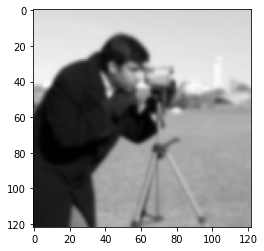

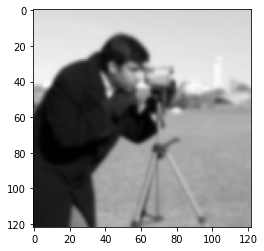

In [104]:
plt.imshow(scipy.signal.convolve(im, kernel,'valid'),'gray')
plt.show()

plt.imshow(convolve(im, kernel,'valid'),'gray')
plt.show()

### Symmetric / rotational invariant filters

#### Low-pass

Low-pass gaussian kernel

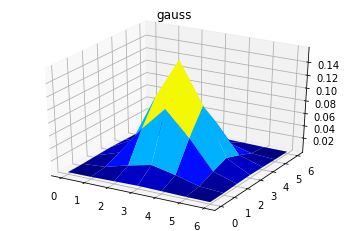

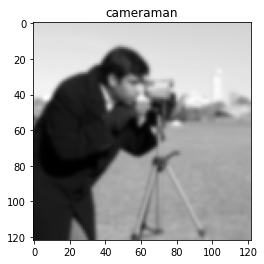

In [105]:
kernel = gauss(7)
_surf(kernel)
plt.title('gauss')
plt.show()

plt.imshow(scipy.signal.convolve(im, kernel,'valid'),'gray')
plt.title('cameraman')
plt.show()
b= scipy.signal.convolve(im, kernel,'valid')

Low-pass box

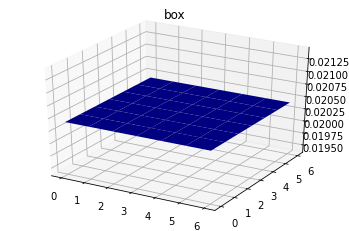

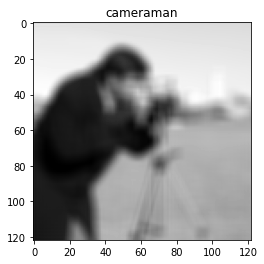

In [106]:
kernel = box(7)
_surf(kernel)
plt.title('box')
plt.show()

plt.imshow(scipy.signal.convolve(im, kernel,'valid'),'gray')
plt.title('cameraman')
plt.show()
b = scipy.signal.convolve(im, kernel,'valid')

Low-pass circle

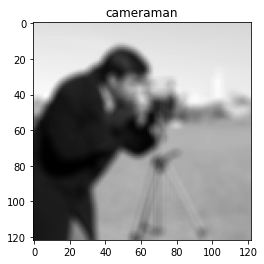

In [107]:
kernel = circle(7,7)
plt.imshow(scipy.signal.convolve(im, kernel,'valid'),'gray')
plt.title('cameraman')
plt.show()

#### High-pass

Laplace 4 and 8 neighbours

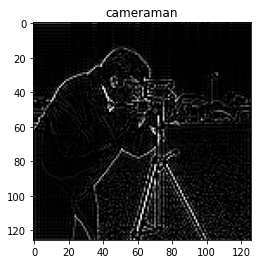

In [108]:
kernel = laplace_4_neighbours()
convolution = coerce(scipy.signal.convolve(im, kernel,'valid'))
plt.imshow(convolution,'gray')
plt.title('cameraman')
plt.show()

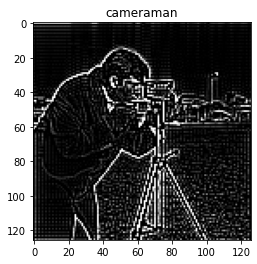

In [109]:
kernel = laplace_8_neighbours()
convolution = coerce(scipy.signal.convolve(im, kernel,'valid'))
plt.imshow(convolution,'gray')
plt.title('cameraman')
plt.show()

High-pass from implemented low-pass filters: high-pass = ID - low-pass

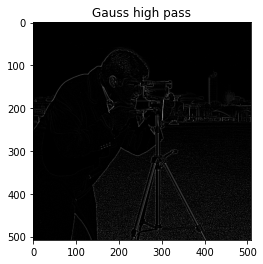

In [110]:
convolution = coerce(scipy.signal.convolve(camera, high_pass(gauss(5)), 'valid'))
plt.imshow(convolution,'gray')
plt.title('Gauss high pass')
plt.show()

#### Band-pass

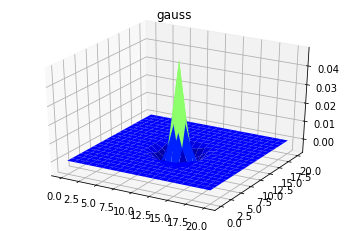

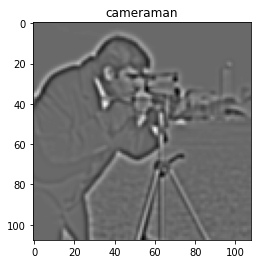

In [111]:
kernel = dog(21,1,1.2)
_surf(kernel)
plt.title('gauss')
plt.show()

convolution = scipy.signal.convolve(im, kernel,'valid')
plt.imshow(convolution,'gray')
plt.title('cameraman')
plt.show()

#### Contrast enhancement filters 

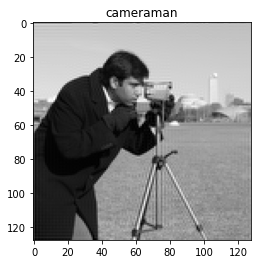

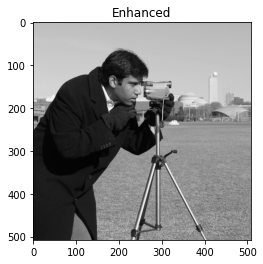

In [112]:
plt.imshow(im,'gray')
plt.title('cameraman')
plt.show()

convolution = scipy.signal.convolve(camera, enhance(5), 'valid')
plt.imshow(convolution,'gray')
plt.title('Enhanced')
plt.show()

### Asymmetric / Differential or directional filter pairs


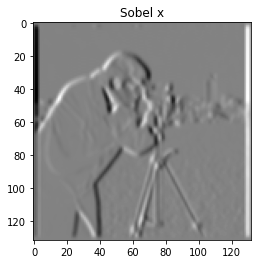

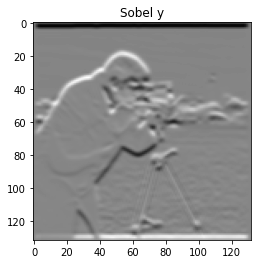

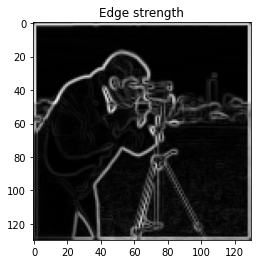

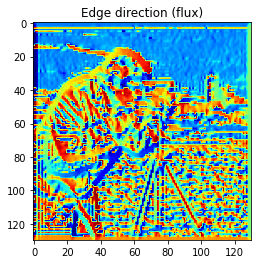

In [113]:
# Sobel x and y
plt.imshow(scipy.signal.convolve(im, sobel(5)[0]),'gray')
plt.title('Sobel x')
plt.show()

plt.imshow(scipy.signal.convolve(im, sobel(5)[1]),'gray')
plt.title('Sobel y')
plt.show()

plt.imshow(edge_detection(im)[0],'gray')
plt.title('Edge strength')
plt.show()

plt.imshow(edge_detection(im)[1],'jet')
plt.title('Edge direction (flux)')
plt.show()

### Implement Sobel-Feldman and Scharr filter-pairs

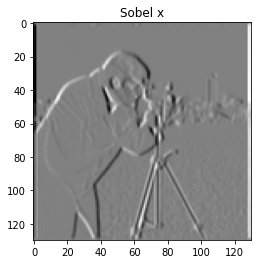

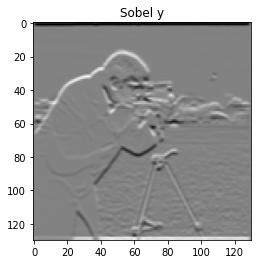

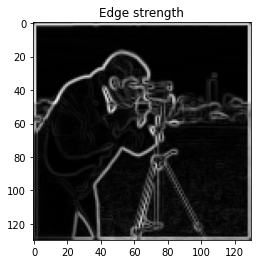

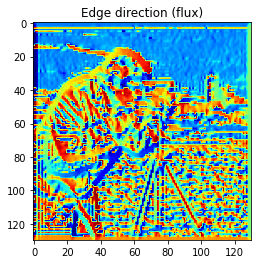

In [114]:
# Sobel-Feldman x and y
x_gradient = scipy.signal.convolve(im, sobel(3)[0])
y_gradient = scipy.signal.convolve(im, sobel(3)[1])
plt.imshow(x_gradient,'gray')
plt.title('Sobel x')
plt.show()

plt.imshow(y_gradient,'gray')
plt.title('Sobel y')
plt.show()

plt.imshow(edge_detection_from_gradientes(x_gradient, y_gradient)[0],'gray')
plt.title('Edge strength')
plt.show()

plt.imshow(edge_detection_from_gradientes(x_gradient, y_gradient)[1],'jet')
plt.title('Edge direction (flux)')
plt.show()

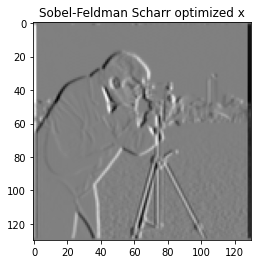

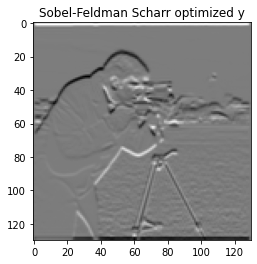

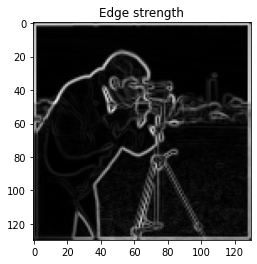

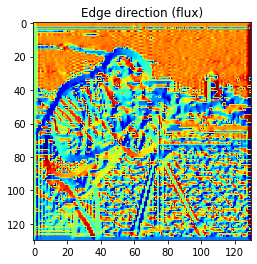

In [115]:
# Sobel-Feldman Scharr optimized
x_gradient = scipy.signal.convolve(im, sobel_optimized()[0])
y_gradient = scipy.signal.convolve(im, sobel_optimized()[1])
plt.imshow(x_gradient,'gray')
plt.title('Sobel-Feldman Scharr optimized x')
plt.show()

plt.imshow(y_gradient,'gray')
plt.title('Sobel-Feldman Scharr optimized y')
plt.show()

plt.imshow(edge_detection_from_gradientes(x_gradient, y_gradient)[0],'gray')
plt.title('Edge strength')
plt.show()

plt.imshow(edge_detection_from_gradientes(x_gradient, y_gradient)[1],'jet')
plt.title('Edge direction (flux)')
plt.show()

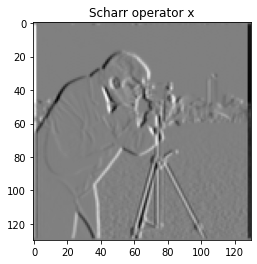

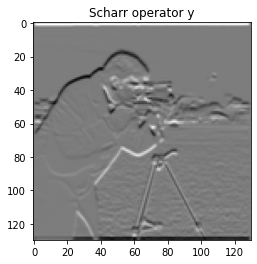

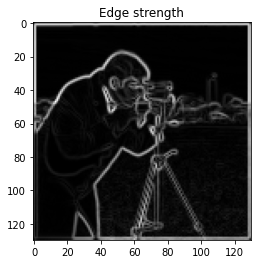

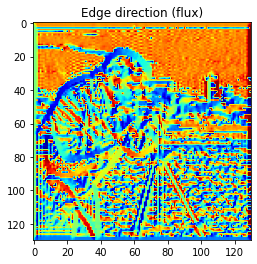

In [116]:
# Scharr operator
x_gradient = scipy.signal.convolve(im, scharr()[0])
y_gradient = scipy.signal.convolve(im, scharr()[1])
plt.imshow(x_gradient,'gray')
plt.title('Scharr operator x')
plt.show()

plt.imshow(y_gradient,'gray')
plt.title('Scharr operator y')
plt.show()

plt.imshow(edge_detection_from_gradientes(x_gradient, y_gradient)[0],'gray')
plt.title('Edge strength')
plt.show()

plt.imshow(edge_detection_from_gradientes(x_gradient, y_gradient)[1],'jet')
plt.title('Edge direction (flux)')
plt.show()

The Sobel-Feldman operator, while reducing artifacts associated with a pure central differences operator, does not have perfect rotational symmetry. The Scharr optimization tries to optimize this property. 
In other side, the Scharr operator it is another optimization, results of minimizing weighted mean squared angular error in the Fourier domain. This last optimization is done under the condition that resulting filters are numerically consistent.

About the original publication, the x-coordinate is defined as increasing in the "left"-direction, while in the current implementation the x-coordinate is defined as increasing in the "right"-direction. There isnt any change in the y-coordinate.

### Canny's edge detection

The first difference between the edge detection using Sobel and Canny is their implementations. 
In the case of Sobel, it is neccesary to convolve a Sobel kernel for x and y, and then with both results, it can be calculated the magnitude and orientation. 
In the case of Canny, the algorithm its more complex. Their steps are:

1 - Apply Gaussian filter to smooth the image in order to remove the noise

2 - Find the intensity gradients of the image

3 - Apply gradient magnitude thresholding or lower bound cut-off suppression 
to get rid of spurious response to edge detection

4 - Apply double threshold to determine potential edges

5 - Track edge by hysteresis: Finalize the detection of edges by suppressing all the other edges that are weak and not connected to strong edges.



In terms of performance, the Canny's algorithm works better than Sobel, but for Canny's it is heavily neccesary to adjust their parameters to reach the best performance (sigma of the gaussian filter and their threshold values T1, and T2).

Canny’s edge detection algorithm is computationally more expensive compared to Sobel but the Canny’s algorithm performs better than Sobel under almost all scenarios.

The Canny's detector is able to detect the maximum number of edges, because it can detect vertical and horizontal edges, but also circular edges and edges at the corner. Sobel show good results for horizontal and vertical edges.